# Анализ пользовательского поведения в мобильном приложении

## Изучение общей информации

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go

In [2]:
df = pd.read_csv('...', sep='\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


<div style="border:solid blue 2px; padding: 20px"> Таблица состоит из 244126 наблюдений, пропусков не наблюдается, столбец 'event_timestamp' записан в формате unix time, столбцы имеют неудобные названия.

## Подготовка данных

Заменим названия столбцов

In [5]:
df.columns = ['event_name', 'user_id', 'event_timestamp', 'test_id']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   test_id          244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Столбец 'event_timestamp' записан в формате unix time. Добавим новые столбцы с датой и временем **`'event_date_time'`** и только датой **`'event_date'`** в формате datetime

In [6]:
df['event_date_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df.head()

,event_name,user_id,event_timestamp,test_id,event_date_time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [7]:
df['event_date'] = pd.to_datetime(df['event_date_time'], format='%Y-%M-%D').dt.date.astype('datetime64[ns]')
df.head()

,event_name,user_id,event_timestamp,test_id,event_date_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   user_id          244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   test_id          244126 non-null  int64         
 4   event_date_time  244126 non-null  datetime64[ns]
 5   event_date       244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


In [9]:
# Проверим на наличие дубликатов
df.duplicated().sum()

413

In [10]:
# Удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

<div style="border:solid blue 2px; padding: 20px"> При подготовке данных заменили названия столбов на более удобные и понятные для нас, добавили новые столбцы с датой в привычном нам формате, а также очистили данные от полных дубликатов.

## Изучение и проверка данных

### Количество событий в логе

In [11]:
df.shape[0]

243713

<div style="border:solid blue 2px; padding: 20px"> Всего в логе после подготовки данных 243713 событий.

### Количество пользователей в логе

In [12]:
len(df['user_id'].unique())

7551

<div style="border:solid blue 2px; padding: 20px"> В логе 7551 уникальных пользователей.

### Среднее количество событий на одного пользователя

In [13]:
round(df.shape[0] / len(df['user_id'].unique()))

32

In [14]:
# Таблица с количеством событий на каждого пользователя
event_user = df.groupby('user_id').agg({'event_name' : 'count'})

In [15]:
event_user.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


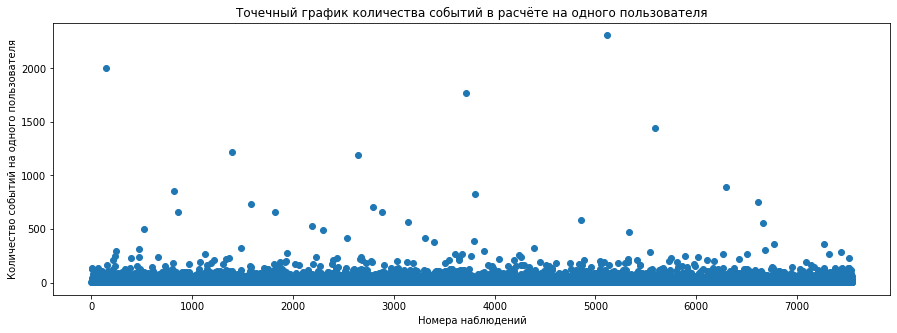

In [16]:
x_values = pd.Series(range(0,len(event_user)))
plt.figure(figsize=(15, 5))
plt.scatter(x_values, event_user)
plt.title('Точечный график количества событий в расчёте на одного пользователя')
plt.xlabel('Номера наблюдений')
plt.ylabel('Количество событий на одного пользователя')
plt.show()

In [17]:
np.percentile(event_user, [90, 95, 99])

array([ 64. ,  89. , 200.5])

<div style="border:solid blue 2px; padding: 20px"> В среднем на пользователя приходится 32 события. При этом наблюдаются отдельные пользователи, на которых приходится гораздо больше событий - 1% пользователей совершили больше 200 событий, максимальное количество событий - 2307, минимальное - 1.

### Анализ временного периода

In [18]:
df['event_date_time'].min()

Timestamp('2019-07-25 04:43:36')

In [19]:
df['event_date_time'].max()

Timestamp('2019-08-07 21:15:17')

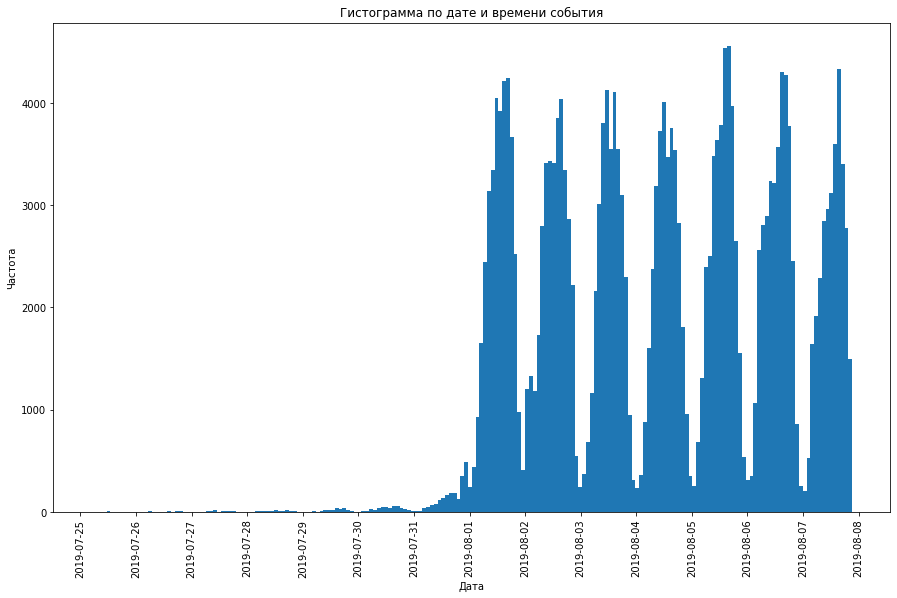

In [20]:
plt.figure(figsize=(15,9))
plt.hist(df['event_date_time'], bins=200)
plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
plt.title('Гистограмма по дате и времени события')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.show()

In [21]:
df_new = df.query('event_date_time >= "2019-08-01"')

<div style="border:solid blue 2px; padding: 20px"> Минимальная дата, которой мы располагаем, '2019-07-25 04:43:36', максимальная - '2019-08-07 21:15:17'. По результатам анализа гистограммы можно заметить, что у нас данные неодинаково полные за весь период, стоит отбросить данные до 1 августа.

### Сколько событий и пользователей потеряли, отбросив старые данные

In [22]:
df.shape[0] - df_new.shape[0]

2826

In [23]:
round((df.shape[0] - df_new.shape[0]) / df.shape[0] * 100, 2)

1.16

In [24]:
len(df['user_id'].unique()) - len(df_new['user_id'].unique())

17

In [25]:
round((len(df['user_id'].unique()) - len(df_new['user_id'].unique())) / len(df['user_id'].unique()) * 100, 2)

0.23

<div style="border:solid blue 2px; padding: 20px"> Отбросив старые данные, мы потеряли 2826 (1,16%) событий и 17 (0,23%) пользователей.

### Проверка на наличие пользователей из всех трёх экспериментальных групп

In [26]:
df_new['test_id'].value_counts()

248    84563
246    79302
247    77022
Name: test_id, dtype: int64

In [27]:
df_new.pivot_table(index='test_id', values='user_id', aggfunc='nunique')

,user_id
test_id,
246,2484
247,2513
248,2537


<div style="border:solid blue 2px; padding: 20px"> Убедились, что в данных присутствуют события и пользователи во всех трёх экспериментальных группах.

## Изучение воронки событий

### События в логах

In [28]:
df_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

<div style="border:solid blue 2px; padding: 20px"> Всего в логе встречается 5 видов событий: MainScreenAppear (главный экран), OffersScreenAppear (экран предложения), CartScreenAppear (экран корзины), PaymentScreenSuccessful (экран успешной оплаты), Tutorial (учебное пособие). Наиболее часто встречается главный экран, наименее часто - учебное пособие.

### Количество пользователей, совершавших каждое из событий. Доля пользователей, которые хоть раз совершали событие

In [29]:
user_event = (
    df_new.groupby('event_name').agg({'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
)
user_event['part_%'] = round(user_event['user_id'] / len(df_new['user_id'].unique()) * 100, 2)
user_event

,event_name,user_id,part_%
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


<div style="border:solid blue 2px; padding: 20px"> Хоть раз посетили главный экран 98,5% пользователей, т.е. 1,5% миновали главный экран, возможно попав на страницу предложения в результате перехода по внешней ссылке. Экран предложения посетили 61% пользователей, 49,6% - экран корзины, 47% дошли до успешной оплаты, и только 11% открыли учебное пособие.

### Исключение событий, не выстраивающихся в последовательную цепочку

In [30]:
user_event = user_event.query('event_name != "Tutorial"')

In [31]:
df_new = df_new.query('event_name != "Tutorial"')

<div style="border:solid blue 2px; padding: 20px"> Логическая последовательность событий: главый экран - экран предложения - экран корзины - экран успешной оплаты. Учебное пособие не встраивается в логическую цепочку. Исключим это событие из дальнейшего анализа.

### Расчет доли пользователей, переходящих на следующий шаг воронки (от числа пользователей на предыдущем)

In [32]:
funnel_A_B = round(user_event['user_id'][1] / user_event['user_id'][0] * 100, 2)
funnel_B_C = round(user_event['user_id'][2] / user_event['user_id'][1] * 100, 2)
funnel_C_D = round(user_event['user_id'][3] / user_event['user_id'][2] * 100, 2)
print(f'C главного экрана на экран предложения переходит {funnel_A_B}% пользователей')
print(f'C экрана предложения на экран корзины переходит {funnel_B_C}% пользователей')
print(f'C экрана корзины на экран успешного платежа переходит {funnel_C_D}% пользователей')

C главного экрана на экран предложения переходит 61.91% пользователей
C экрана предложения на экран корзины переходит 81.3% пользователей
C экрана корзины на экран успешного платежа переходит 94.78% пользователей


### Определение шага, на котором теряется больше всего пользователей

In [ ]:
fig = go.Figure(go.Funnel(
    y = user_event.event_name, 
    x = user_event.user_id, 
    textposition = "inside", 
    textinfo = "value+percent previous+percent initial"))
fig.update_layout(title = "Воронка событий", yaxis_title="Событие")
fig.show()

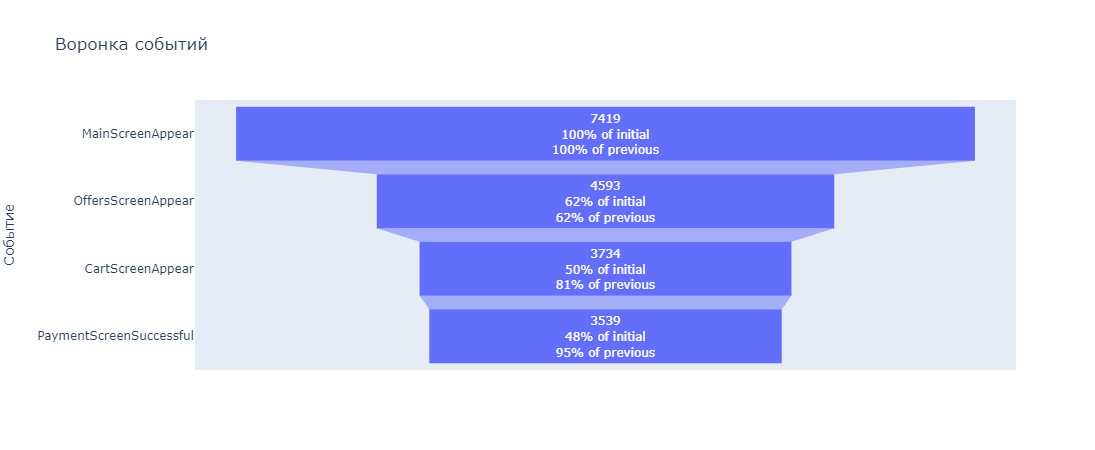

<div style="border:solid blue 2px; padding: 20px"> Больше всего пользователей теряется на первом шаге: только 62% переходит с главной страницы на страницу предложения.

### Доля пользователей, доходящих от первого события до оплаты

In [34]:
funnel_A_D = round(user_event['user_id'][3] / user_event['user_id'][0] * 100, 2)
print(f'C главного экрана до оплаты доходит {funnel_A_D}% пользователей')

C главного экрана до оплаты доходит 47.7% пользователей


## Изучение результатов эксперимента

### Количество пользователей в каждой экспериментальной группе. Проверка статистическими критериями разницы между выборками 246 и 247.

In [35]:
df_test_group = df_new.groupby('test_id').agg({'user_id' : 'nunique'}).reset_index()
df_test_group

,test_id,user_id
0,246,2483
1,247,2512
2,248,2535


Один из критериев успешного А/А-теста: количество пользователей в различных группах различается не более, чем на 1%. Проверим наши группы на соответствие этому критерию.

In [36]:
round(df_test_group['user_id'][0] / df_test_group['user_id'][1] * 100 - 100, 2)

-1.15

In [37]:
df_246 = df_new.query('test_id == 246')
df_247 = df_new.query('test_id == 247')
df_248 = df_new.query('test_id == 248')

Ещё один критерий успешного разделения на группы - отсутствие пересекающихся пользователей.

In [38]:
# Проверим наличие пересекающихся пользователей
len(df_246.merge(df_247, on='user_id')['user_id'].unique())

0

In [39]:
len(df_246.merge(df_248, on='user_id')['user_id'].unique())

0

In [40]:
len(df_248.merge(df_247, on='user_id')['user_id'].unique())

0

Имеют ли выборки статистически значимые отличия проверим с помощью z-теста. Для этого напишем функцию.

In [41]:
def test_aa(trials, successes, alpha):

    
    alpha = alpha # критический уровень статистической значимости

    # Пропорции в группах
    p0 = successes[0] / trials[0]
    p1 = successes[1] / trials[1]

    # Пропорция в комбинированном датасете:
    p_combined = (successes[0] + successes[1])/(trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p0 - p1

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:',p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.")

In [42]:
# Сформируем таблицу с количеством пользователей в каждой группе с разбивкой по событиям.
df_group = (
    df_new.pivot_table(index='event_name', columns='test_id', values='user_id', aggfunc='nunique')
    .sort_values(by=246, ascending=False).reset_index()
)
df_group.columns = ['event_name', 'no_246', 'no_247', 'no_248']
df_group

,event_name,no_246,no_247,no_248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Сформулируем гипотезы для каждого события 'event_name':

- Н0: Между долями пользователей события от общего количества пользователей в группах 246 и 247 соответственно нет разницы
- Н1: Между долями пользователей события от общего количества пользователей в группах 246 и 247 соответственно есть разница

In [43]:
for i in range(len(df_group)):
    trials = df_test_group.user_id[[0,1]]
    successes = list([df_group.loc[i, 'no_246'], df_group.loc[i, 'no_247']])
    print(f'Для события {df_group.event_name[i]}:')
    test_aa(trials, successes, 0.05)
    print()

Для события MainScreenAppear:
p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события OffersScreenAppear:
p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события CartScreenAppear:
p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события PaymentScreenSuccessful:
p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



<div style="border:solid blue 2px; padding: 20px"> Разбиение на группы работает корректно, между контрольными группами нет разницы в разбивке на группы, дошедших до определенного этапа. А/А тест можно считать успешным.

### Число и доля пользователей, совершивших самое популярное событие в каждой из контрольных групп

Добавим в таблицы данные для объединенной группы и посчитаем доли.

In [44]:
df_test_group.loc[3,:] = df_test_group.loc[0,:] + df_test_group.loc[1,:]
df_test_group.loc[3,'test_id'] = '246+247'
df_test_group

,test_id,user_id
0,246.0,2483.0
1,247.0,2512.0
2,248.0,2535.0
3,246+247,4995.0


In [45]:
df_group['no_246+247'] = df_group['no_246'] + df_group['no_247']
df_group

,event_name,no_246,no_247,no_248,no_246+247
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [46]:
df_group['no_246_part'] = round(df_group['no_246'] / df_test_group.loc[0,'user_id'],2)
df_group['no_247_part'] = round(df_group['no_247'] / df_test_group.loc[1,'user_id'],2)
df_group['no_248_part'] = round(df_group['no_248'] / df_test_group.loc[2,'user_id'],2)
df_group['no_246+247_part'] = round(df_group['no_246+247'] / df_test_group.loc[3,'user_id'],2)
df_group

,event_name,no_246,no_247,no_248,no_246+247,no_246_part,no_247_part,no_248_part,no_246+247_part
0,MainScreenAppear,2450,2476,2493,4926,0.99,0.99,0.98,0.99
1,OffersScreenAppear,1542,1520,1531,3062,0.62,0.61,0.60,0.61
2,CartScreenAppear,1266,1238,1230,2504,0.51,0.49,0.49,0.50
3,PaymentScreenSuccessful,1200,1158,1181,2358,0.48,0.46,0.47,0.47


<div style="border:solid blue 2px; padding: 20px"> Самым популярным событием является главный экран, во всех группах доля пользователей, совершивших это событие, практически одинакова. Доли для других событий также практически не отличаются. Далее проверим, имеют ли эти небольшие различия статистическую значимость.

### Проверка статистической достоверности между группами.

Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим метод корректировки уровня значимости Бонферрони. Т.к. будем рассматривать три пары групп по 4 события, то разделим уровень значимости alpha = 0,05  на 12.

In [47]:
bonferroni_alpha = 0.05 / 12

Сформулируем гипотезы для каждого события 'event_name':

- Н0: Между долями пользователей события от общего количества пользователей в группах 247 и 248 соответственно нет разницы
- Н1: Между долями пользователей события от общего количества пользователей в группах 247 и 248 соответственно есть разница

In [48]:
for i in range(len(df_group)):
    trials = list(df_test_group.user_id[[1,2]])
    successes = list([df_group.loc[i, 'no_247'], df_group.loc[i, 'no_248']])
    print(f'Для события {df_group.event_name[i]}:')
    test_aa(trials, successes, bonferroni_alpha)
    print()

Для события MainScreenAppear:
p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события OffersScreenAppear:
p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события CartScreenAppear:
p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события PaymentScreenSuccessful:
p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Сформулируем гипотезы для каждого события 'event_name':

- Н0: Между долями пользователей события от общего количества пользователей в группах 246 и 248 соответственно нет разницы
- Н1: Между долями пользователей события от общего количества пользователей в группах 246 и 248 соответственно есть разница

In [49]:
for i in range(len(df_group)):
    trials = list(df_test_group.user_id[[0,2]])
    successes = list([df_group.loc[i, 'no_246'], df_group.loc[i, 'no_248']])
    print(f'Для события {df_group.event_name[i]}:')
    test_aa(trials, successes, bonferroni_alpha)
    print()

Для события MainScreenAppear:
p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события OffersScreenAppear:
p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события CartScreenAppear:
p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события PaymentScreenSuccessful:
p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Сформулируем гипотезы для каждого события 'event_name':

- Н0: Между долями пользователей события от общего количества пользователей в группах 246+247 и 248 соответственно нет разницы
- Н1: Между долями пользователей события от общего количества пользователей в группах 246+247 и 248 соответственно есть разница

In [50]:
for i in range(len(df_group)):
    trials = list(df_test_group.user_id[[2,3]])
    successes = list([df_group.loc[i, 'no_248'], df_group.loc[i, 'no_246+247']])
    print(f'Для события {df_group.event_name[i]}:')
    test_aa(trials, successes, bonferroni_alpha)
    print()

Для события MainScreenAppear:
p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события OffersScreenAppear:
p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события CartScreenAppear:
p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Для события PaymentScreenSuccessful:
p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



<div style="border:solid blue 2px; padding: 20px"> В результате не получилось отвергнуть ни одной нулевой гипотезы, т.е. у нас нет оснований считать, что между долями пользователей в каждой из групп, дошедших до определенного события есть различия. При этом значения p_value настолько высокие, что даже без поправок на множественные сравнения при уровне значимости 0,05 ни одна из нулевых гипотез не была бы отвергнута. Проверку на статистичекую значимость при уровне 0,1 вижу нецелесообразным, т.к. с учетом поправки Бонферрони результаты проверки останутся прежними.

## Выводы  

Таким образом, по результатм анализа воронки продаж и А/А/В-тестирования с 1 по 7 августа 2019 года стоит отметить:
- Почти 48% пользователей доходит с главного экрана до успешной оплаты заказа, при этом на главном экране теряется больше всего пользователей - только 62% переходят на экран с предложением.
- Учебное пособие никак не встраивается в логическую цепочку, данную страницу посещают только 11% пользователей.
- По результатам А/А/В-тестирования не наблюдается статистически значимой разницы между группами, т.е. изменение шрифтов в приложении не повлияло на пропорции пользователей, переходящих с одного этапа воронки на другой.
<div>
    Рекомендуется более подробно рассмотреть причины, по которым почти 40% пользователей отсеиваются на этапе главного экрана приложения.



